
--- Starting file processing ---
Reading data from file: FE_RADDIS_H-WAT.csv
Reading data from file: GA_RADDIS_H-WAT.csv
Reading data from file: FE_RADDIS_H-H.csv
Reading data from file: GA_RADDIS_H-H.csv


C:\Users\uah\AppData\Local\Temp\ipykernel_3724\1917339085.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_density = df.groupby('Distance_Bin')['Density_Value'].sum().reset_index()
C:\Users\uah\AppData\Local\Temp\ipykernel_3724\1917339085.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_density = df.groupby('Distance_Bin')['Density_Value'].sum().reset_index()
C:\Users\uah\AppData\Local\Temp\ipykernel_3724\1917339085.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

--- File processing complete ---

Successfully loaded 4 out of 4 files.

Graph saved successfully as: polar_density_comparison_4_files.png


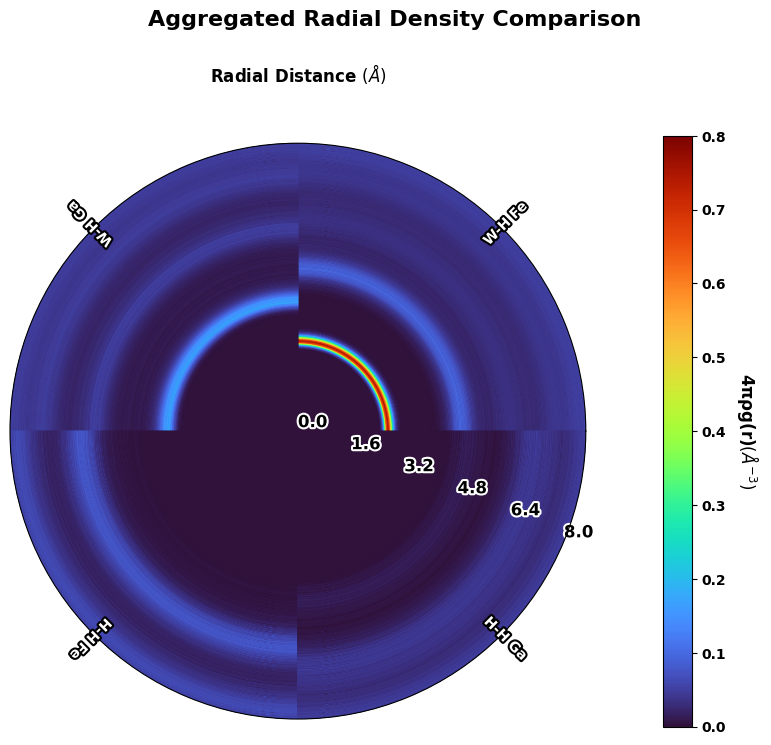

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import os 
from math import pi

# --- CONFIGURATION ---
# IMPORTANT! Assign a LIST of your CSV file names here.
# All CSVs must use a comma (,) as a delimiter and have the same column format.
# Example: FILE_NAMES = ['file1.csv', 'file2.csv', 'file3.csv']
FILE_NAMES = ['FE_RADDIS_H-WAT.csv', 'GA_RADDIS_H-WAT.csv', 'FE_RADDIS_H-H.csv', 'GA_RADDIS_H-H.csv'] 
SEGMENT_LABELS = ['W-H Fe', 'W-H Ga', 'H-H Fe', "H-H Ga"] # Labels for each segment (must match the count of FILE_NAMES)
BIN_WIDTH_ANGSTROM = 0.01 # Width of the radial bins (0.1 Å)

# RADIAL AXIS (R) RANGE
MIN_R_LIMIT_DISPLAY = 0.0 # Inner limit for R. None = uses 0.0.
MAX_R_LIMIT_DISPLAY = 8.0 # Outer limit for R. None = uses the maximum distance in the data.


# COLOR SCALE (Z) RANGE
MIN_Z_LIMIT_DISPLAY = 0.0 # Lower limit for the color scale (density). None = uses the min of all data.
MAX_Z_LIMIT_DISPLAY = 0.8 # Upper limit for the color scale (density). None = uses the max of all data.

def process_single_csv(file_path):
    """
    Loads the CSV and aggregates density into defined radial bins.
    Returns the radial boundaries (R_bins), aggregated density values (Density_values), and max data distance.
    """
    
    # --- DATA LOADING ---
    if not os.path.exists(file_path):
        print(f"!!! Error: The file '{file_path}' was NOT found. Skipping this file. !!!")
        return None, None, None

    print(f"Reading data from file: {file_path}")
    
    read_csv_params = {
        'filepath_or_buffer': file_path,
        'sep': ',',
        'skiprows': 1,
        'header': None,
        'names': ['Distance', 'Density_Value'],
        'decimal': '.'
    }

    try:
        df = pd.read_csv(**read_csv_params)
    except Exception as e:
        print(f"Error reading CSV {file_path}: {e}.")
        return None, None, None

    # Data Cleaning and Conversion
    df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')
    df['Density_Value'] = pd.to_numeric(df['Density_Value'], errors='coerce')
    df.dropna(inplace=True)

    if df.empty:
        print(f"DataFrame is empty after data cleaning for {file_path}. Skipping.")
        return None, None, None

    # --- DATA AGGREGATION (0.1 Å Bins) ---
    max_data_distance = df['Distance'].max()
    
    # Define bins
    bins = np.arange(0, max_data_distance + BIN_WIDTH_ANGSTROM, BIN_WIDTH_ANGSTROM)
    if bins[-1] < max_data_distance:
        bins = np.append(bins, bins[-1] + BIN_WIDTH_ANGSTROM)
        
    df['Distance_Bin'] = pd.cut(df['Distance'], bins=bins, include_lowest=True, right=True)
    aggregated_density = df.groupby('Distance_Bin')['Density_Value'].sum().reset_index()
    
    # R (Radial Axis) Nodes/Borders
    bin_labels = [b.right for b in aggregated_density['Distance_Bin']]
    R_bins = np.array([0.0] + bin_labels)
    
    # Density values
    density_values = aggregated_density['Density_Value'].values
    
    return R_bins, density_values, df['Distance'].max()


def generate_multi_polar_plot(file_paths, segment_labels):
    """
    Processes multiple CSVs and creates a segmented polar heatmap.
    """
    
    if not file_paths or len(file_paths) == 0:
        print("Error: No file paths provided.")
        return
    
    # Validate that labels and files match in quantity
    if len(file_paths) != len(segment_labels):
        print("Error: The number of files in FILE_NAMES must match the number of labels in SEGMENT_LABELS.")
        return
    
    # --- 1. PROCESS ALL DATA ---
    all_data = []
    max_r_data_global = 0.0
    
    print("\n--- Starting file processing ---")
    for i, file_path in enumerate(file_paths):
        R_bins, density_values, max_dist = process_single_csv(file_path)
        if R_bins is not None:
            all_data.append({
                'file_path': file_path,
                'R_bins': R_bins,
                'Density_values': density_values,
                'max_dist': max_dist,
                # Uses the user-defined label
                'label': segment_labels[i] 
            })
            max_r_data_global = max(max_r_data_global, max_dist)
    print("--- File processing complete ---\n")

    num_loaded_files = len(all_data)

    if num_loaded_files < 1:
        print("No valid data found in any of the files. Cannot generate plot.")
        return
    
    print(f"Successfully loaded {num_loaded_files} out of {len(file_paths)} files.")
    
    # If only one file is loaded, generate a full circle (as before)
    if num_loaded_files == 1:
        print("NOTE: Only one file was loaded. The plot will display a full circle.")
    
    # --- 2. GLOBAL PREPARATION (R and Z Limits) ---
    
    R_max_display = MAX_R_LIMIT_DISPLAY if MAX_R_LIMIT_DISPLAY is not None else max_r_data_global
    R_min_display = MIN_R_LIMIT_DISPLAY if MIN_R_LIMIT_DISPLAY is not None else 0.0
    
    if R_min_display >= R_max_display:
        R_min_display = 0.0
    
    all_density_values = np.concatenate([d['Density_values'] for d in all_data])
    min_z_data = np.min(all_density_values)
    max_z_data = np.max(all_density_values)
    
    vmin_z = MIN_Z_LIMIT_DISPLAY if MIN_Z_LIMIT_DISPLAY is not None else min_z_data
    vmax_z = MAX_Z_LIMIT_DISPLAY if MAX_Z_LIMIT_DISPLAY is not None else max_z_data
    
    if vmin_z >= vmax_z:
        vmin_z = min_z_data
        vmax_z = max_z_data
    
    # --- 3. POLAR PLOTTING (SEGMENTATION) ---
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    ax.grid(False) 
    
    # Angular segmentation calculation
    # If only one file is loaded, it gets the full 2*pi angle.
    angle_per_segment = 2 * pi / num_loaded_files
    num_angular_segments_res = 100 
    
    im = None
    
    for i, data in enumerate(all_data):
        
        # 3.1. Define Theta (Angular Axis) for the current segment
        start_angle = i * angle_per_segment
        end_angle = (i + 1) * angle_per_segment
        
        # Theta nodes for the segment (N_segments + 1)
        Theta_seg = np.linspace(start_angle, end_angle, num_angular_segments_res + 1)
        
        R_seg = data['R_bins']
        density_values = data['Density_values']
        
        # 3.2. Define Z (Color Data) for the current segment
        R_size = R_seg.size
        Z_base_seg = np.tile(density_values, (num_angular_segments_res, 1)).T 

        Z_angular_padded_seg = np.hstack((Z_base_seg, Z_base_seg[:, [0]])) 
        Z_seg = np.vstack((Z_angular_padded_seg, Z_angular_padded_seg[-1, :]))

        # 3.3. PLOT the segment
        im = ax.pcolormesh(
            Theta_seg, R_seg, Z_seg, 
            cmap='turbo', 
            shading='gouraud', 
            vmin=vmin_z,
            vmax=vmax_z
        )
            
        # 3.4. Add Label to the Segment (With Black Halo)
        label_angle = (start_angle + end_angle) / 2
        
        # Segment label with a black border (Halo).
        # Simplified to use only one ax.text call,
        # with white text and a black path effect.
        ax.text(
            label_angle, 
            R_max_display * 1.02, 
            data['label'], 
            ha='center', 
            va='center', 
            fontsize=10, 
            fontweight='bold',
            rotation=np.degrees(label_angle),
            color='white', # Changed the main text to WHITE
            path_effects=[path_effects.withStroke(linewidth=3, foreground="black")] # BLACK border
        )

    
    # --- 4. Aesthetic Configuration (Common to all) ---
    
    fig.suptitle(
        'Aggregated Radial Density Comparison',
        fontsize=16,
        fontweight='bold',
        y=0.98 
    )
    
    # Radial Axis Ticks
    ax.set_rlim(R_min_display, R_max_display) 
    
    # Set tick positions
    r_ticks_display = np.linspace(R_min_display, R_max_display, num=min(R_seg.size, 6)).round(2)
    if R_min_display == 0.0 and 0.0 not in r_ticks_display:
        r_ticks_display = np.insert(r_ticks_display, 0, 0.0)
    r_ticks_display = r_ticks_display[r_ticks_display >= R_min_display]
    
    ax.set_rticks(r_ticks_display) 
    ax.set_rlabel_position(-22.5) 
    
    # Apply border to radial tick labels
    ax.tick_params(axis='y', labelsize=12, pad=15) 
    
    rtick_labels = ax.get_yticklabels()
    for label in rtick_labels:
        # Keep the main text black for radial ticks
        label.set_color('black') 
        label.set_fontweight('bold')
        # Add path effect for the WHITE border
        label.set_path_effects([path_effects.withStroke(linewidth=3, foreground="white")])
    
    # Angular Axis (Hidden)
    ax.set_xticklabels([]) 
    ax.set_xticks([])

    # Color Bar (Legend)
    if im is not None:
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1, shrink=0.85)
        cbar.set_label(r'$\mathbf{4 \pi \rho g(r)} (\AA^{-3})$', rotation=270, labelpad=25, fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10) 
        for t in cbar.ax.get_yticklabels():
            t.set_fontweight('bold') 

    # Radial Axis Title/Label
    ax.text(
        pi/2, 
        R_max_display + 0.20 * R_max_display, 
        r'Radial Distance $(\AA)$',
        ha='center', 
        va='bottom', 
        fontsize=12,
        color='black',
        fontweight='bold' 
    )

    # Final layout adjustment
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # --- SAVE FIGURE ---
    png_filename = f"polar_density_comparison_{num_loaded_files}_files.png"
    
    try:
        plt.savefig(png_filename, dpi=300)
        print(f"\nGraph saved successfully as: {png_filename}")
    except Exception as e:
        print(f"\nError saving PNG file: {e}")

    plt.show()

# --- EXECUTION ---
if __name__ == '__main__':
    generate_multi_polar_plot(file_paths=FILE_NAMES, segment_labels=SEGMENT_LABELS)